In [24]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table
from tqdm import tqdm
from odc.stac import stac_load
from datetime import datetime, timedelta
import seaborn as sns

from IPython.display import Image

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Choose an area and time of interest

Trial: searching for assets acquired over Vietname in during the Nov - Dec 2021. You can use the [Planetary Computer Explorer](https://planetarycomputer.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [4]:
lat, lon = [10.583364246115156, 105.23946127195805]
buffer = 0.1
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]
search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime='2021-11-30/2021-12-10'
    )
items = search.get_all_items()
print(f"Found {len(items)} items")
item = items[0]

Found 4 items


# Draw out the VV, VH

Drawing out the VV and VH data from the 1st asset derived from above code block.

In [5]:
data = stac_load([items[0]], patch_url=planetary_computer.sign, bbox=bbox).isel(time=0)
vh = data["vh"].astype("float").values.tolist()[0][0]
vv = data["vv"].astype("float").values.tolist()[0][0]
print(vh,vv)

-32768.0 -32768.0


In [9]:
def get_sentinel_data(latlong,buffer,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    buffer - the sentinel pixel size
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    lat, lon = float(latlong[0]),float(latlong[1])
    bbox_of_interest = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace,
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = search.get_all_items()
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=planetary_computer.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv


def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

def get_vv_vh(data, time_slice, destination):
    vh_vv = []
    for coordinates in tqdm(cord_data['Latitude and Longitude']):
        vh_vv.append(get_sentinel_data(coordinates, buffer, time_slice, assests))
    vh_vv_data = pd.DataFrame(vh_vv,columns =[f'vh{str(time_slice)[:10]}',f'vv{str(time_slice)[:10]}'])
    data = combine_two_datasets(data,vh_vv_data)
    data.to_pickle(destination)

# check whether such date range contains Sentinel-1 dataset or not

In [7]:
for dt in pd.date_range(start='8/1/2022', end='11/1/2022', freq='1M'):
    dt = str(dt)[:10]+'/'+str(dt+timedelta(days=10))[:10]
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime=dt
    )
    items = search.get_all_items()
    print(f"Found {len(items)} items on {dt}")

Found 2 items on 2022-08-31/2022-09-10
Found 2 items on 2022-09-30/2022-10-10
Found 2 items on 2022-10-31/2022-11-10


In [8]:
# ## MANUAL Function call to extract VV,VH Values and store it as `data.pkl`
# time_slice = "2022-07-31/2022-08-10"
# buffer = 0.1
# assests = ['vh','vv']
# vh_vv = []
# for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
#     vh_vv.append(get_sentinel_data(coordinates,buffer,time_slice,assests))
# vh_vv_data = pd.DataFrame(vh_vv,columns =[f'vh{str(time_slice)[:10]}',f'vv{str(time_slice)[:10]}'])
# data = combine_two_datasets(data,vh_vv_data)
# data.to_pickle('data.pkl')
# data

In [10]:
## Gathering VV VH data for model training across desired date ranges Nov 2021 to Feb 2023
cord_data = pd.read_pickle('submission_data_cord.pkl')
buffer = 0.1
assests = ['vh','vv']

for dt in pd.date_range(start='11/1/2021', end='2/24/2023', freq='1M'):
    time_slice = str(dt)[:10]+'/'+str(dt+timedelta(days=10))[:10]
    data = pd.read_pickle('data.pkl')
    get_vv_vh(data, time_slice)
print('done')

In [11]:
data = pd.read_pickle('data.pkl')
data

,Latitude and Longitude,Class of Land,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,vv2022-05-31,...,vh2021-12-31,vv2021-12-31,vh2023-01-31,vv2023-01-31,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31
0,"(10.323727047081501, 105.2516346045924)",Rice,0.025809,0.046758,0.040087,0.258022,0.011501,0.088195,0.041798,0.050357,...,0.010518,0.156729,0.040087,0.032296,0.024688,0.356259,0.018502,0.090875,0.035976,0.038166
1,"(10.322364360592521, 105.27843410554115)",Rice,0.028435,0.040619,0.005701,0.043889,0.036218,0.090976,0.009128,0.086131,...,0.032027,0.449675,0.017015,0.033698,0.034930,0.263210,0.014791,0.218032,0.018949,0.071743
2,"(10.321455902933202, 105.25254306225168)",Rice,0.042243,0.198050,0.065652,0.250058,0.024159,0.474126,0.046006,0.257310,...,0.019711,0.211141,0.019109,0.060927,0.024080,0.222509,0.027287,0.237095,0.031852,0.272413
3,"(10.324181275911162, 105.25118037576274)",Rice,0.032050,0.078635,0.031070,0.249539,0.007604,0.273698,0.044662,0.122891,...,0.011051,0.228284,0.025592,0.048524,0.059220,0.244447,0.079248,0.181485,0.055652,0.056386
4,"(10.324635504740822, 105.27389181724476)",Rice,0.013208,0.091704,0.004054,0.025380,0.024947,0.118164,0.019297,0.036611,...,0.050471,0.189949,0.040645,0.054595,0.018596,0.349119,0.027721,0.063309,0.092848,0.102218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.027245,0.046894,0.013554,0.270339,0.004356,0.061393,0.022850,0.106196,...,0.011759,0.076502,0.023796,0.035077,0.003232,0.023702,0.003485,0.012488,0.002454,0.008812
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.022118,0.063891,0.017555,0.273152,0.003530,0.076637,0.008811,0.219475,...,0.018867,0.063373,0.027390,0.067073,0.003879,0.033681,0.003511,0.037849,0.009723,0.015819
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.035172,0.134629,0.022562,0.397861,0.015263,0.178932,0.019894,0.321736,...,0.030432,0.070966,0.033705,0.084863,0.021707,0.090829,0.012015,0.097578,0.036001,0.041303
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.010541,0.036208,0.012637,0.256354,0.004602,0.066129,0.032420,0.191806,...,0.029417,0.062480,0.038003,0.048333,0.002905,0.011732,0.003243,0.008442,0.003742,0.004128


In [19]:
submission_data = pd.read_csv('challenge_1_submission.csv', usecols=['id'])
submission_data.columns=['Latitude and Longitude']
submission_data.to_pickle('submission_data.pkl')

In [20]:
submission_data

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"
...,...
245,"(10.308283266873062, 105.50872812216863)"
246,"(10.582910017285496, 105.23991550078767)"
247,"(10.581547330796518, 105.23991550078767)"
248,"(10.629241357910818, 105.15315779432643)"


In [18]:
## Gathering VV VH data for in order to make the prediction
cord_data = pd.read_pickle('submission_data_cord.pkl')
buffer = 0.1
assests = ['vh','vv']

for dt in pd.date_range(start='11/1/2021', end='2/24/2023', freq='1M'):
    time_slice = str(dt)[:10]+'/'+str(dt+timedelta(days=10))[:10]
    data = pd.read_pickle('submission_data.pkl')
    get_vv_vh(data, time_slice)
print('done')

In [12]:
sub_data = pd.read_pickle('submission_data.pkl')
sub_data

,Latitude and Longitude,vh2021-12-31,vv2021-12-31,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,...,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31,vh2022-11-30,vv2022-11-30,vh2023-01-31,vv2023-01-31
0,"(10.18019073690894, 105.32022315786804)",0.024887,0.420412,0.032572,0.026235,0.074218,0.326084,0.019006,0.194885,0.024442,...,0.017848,0.258637,0.032971,0.059533,0.029771,0.067935,0.042868,0.210826,0.021734,0.036966
1,"(10.561107033461816, 105.12772097986661)",0.029834,0.102679,0.043230,0.083787,0.013753,0.054234,0.033759,0.110243,0.023815,...,0.028224,0.140003,0.031743,0.142211,0.019296,0.140753,0.023259,0.160994,0.017828,0.051285
2,"(10.623790611954897, 105.13771401411867)",0.043791,0.063958,0.024425,0.067639,0.007534,0.042714,0.015497,0.032946,0.046273,...,0.020280,0.158912,0.007301,0.367683,0.022714,0.130159,0.034239,0.052218,0.076482,0.106362
3,"(10.583364246115156, 105.23946127195805)",0.027628,0.068491,0.034561,0.092048,0.028700,0.021269,0.040093,0.228477,0.021459,...,0.030894,0.151874,0.022912,0.162411,0.037030,0.066545,0.046395,0.360840,0.030656,0.067947
4,"(10.20744446668854, 105.26844107128906)",0.031317,0.405673,0.028063,0.031049,0.060399,0.265872,0.060655,0.150903,0.030741,...,0.010483,0.649276,0.023612,0.054151,0.031875,0.049799,0.003434,0.022248,0.037201,0.031332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,"(10.308283266873062, 105.50872812216863)",0.023306,1.279871,0.042283,1.552791,0.039890,1.037688,0.035218,0.894476,0.032241,...,0.018037,0.865080,0.009503,0.789477,0.021589,0.326405,0.020802,0.636473,0.024804,1.191021
246,"(10.582910017285496, 105.23991550078767)",0.017510,0.040552,0.041834,0.063640,0.008622,0.077661,0.019350,0.427270,0.023298,...,0.012358,0.216565,0.021334,0.112711,0.027071,0.097601,0.023541,0.155663,0.031585,0.052805
247,"(10.581547330796518, 105.23991550078767)",0.015218,0.034978,0.039442,0.057817,0.010188,0.017719,0.012933,0.575292,0.015842,...,0.010555,0.091680,0.032574,0.133027,0.048473,0.071016,0.045243,0.080795,0.062070,0.072308
248,"(10.629241357910818, 105.15315779432643)",0.008690,0.017403,0.030527,0.209669,0.054499,0.115431,0.008939,0.409741,0.073876,...,0.008816,0.016422,0.004519,0.017020,0.003895,0.005679,0.005485,0.009926,0.029364,0.199689


# Exploratory data analysis (EDA)

Since we get the training dataset and label dataset, it's time to do the EDA

In [ ]:
data.to_csv('unreviewed_data.csv',index=false)
sub_data.to_csv('unreviewed_data.csv',index=false)

After a thorough check via MS Excel program, I found out that there are "-32768" values which indicates there's no VV or VH data from Sentinel dataset. Therefore, I decided to remove those columns that contain incomplete data set.

In [86]:
df_data = data.drop(columns=['vh2021-11-30','vh2022-02-28','vh2022-12-31','vv2021-11-30','vv2022-02-28','vv2022-12-31'])
df_data.to_pickle('data.pkl')

df_submission = sub_data.drop(columns=['vh2022-02-28','vh2022-12-31','vv2022-02-28','vv2022-12-31'])
df_submission.to_pickle('submission_data.pkl')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude and Longitude  600 non-null    object 
 1   Class of Land           600 non-null    object 
 2   vh2022-01-31            600 non-null    float64
 3   vv2022-01-31            600 non-null    float64
 4   vh2022-03-31            600 non-null    float64
 5   vv2022-03-31            600 non-null    float64
 6   vh2022-04-30            600 non-null    float64
 7   vv2022-04-30            600 non-null    float64
 8   vh2022-05-31            600 non-null    float64
 9   vv2022-05-31            600 non-null    float64
 10  vh2022-06-30            600 non-null    float64
 11  vv2022-06-30            600 non-null    float64
 12  vh2022-07-31            600 non-null    float64
 13  vv2022-07-31            600 non-null    float64
 14  vh2022-11-30            600 non-null    fl

In [ ]:
data.describe()

,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,vv2022-05-31,vh2022-06-30,vv2022-06-30,...,vh2021-12-31,vv2021-12-31,vh2023-01-31,vv2023-01-31,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.028325,0.101680,0.032195,0.183857,0.031237,0.172383,0.036057,0.135209,0.033996,0.180850,...,0.026831,0.140045,0.029487,0.106488,0.032091,0.184539,0.026391,0.111853,0.026701,0.104732
std,0.022523,0.152612,0.029853,0.178525,0.025159,0.198232,0.031507,0.212433,0.028867,0.223710,...,0.025426,0.194804,0.024434,0.191224,0.028455,0.221812,0.031166,0.177280,0.030034,0.168594
min,0.001565,0.005656,0.002036,0.002867,0.001501,0.004457,0.001744,0.004359,0.001713,0.006251,...,0.002007,0.003294,0.001780,0.008187,0.001105,0.004197,0.000877,0.002108,0.001031,0.002328
25%,0.013473,0.034273,0.009799,0.058018,0.012322,0.053422,0.014564,0.039374,0.014725,0.057229,...,0.009982,0.038290,0.013805,0.031411,0.010667,0.050087,0.004550,0.016274,0.004818,0.011914
50%,0.023910,0.071170,0.025028,0.163707,0.026733,0.130806,0.028909,0.088277,0.028752,0.136507,...,0.021030,0.091064,0.023966,0.065547,0.026673,0.144144,0.012224,0.051551,0.014550,0.055926
75%,0.038129,0.129906,0.044810,0.260999,0.042498,0.236353,0.047817,0.184157,0.045161,0.239951,...,0.035641,0.188442,0.038577,0.132477,0.043662,0.244546,0.037530,0.168337,0.039499,0.139548
max,0.208103,3.040091,0.222356,2.099736,0.217388,3.221357,0.204258,4.265116,0.296396,3.936735,...,0.232647,3.316325,0.208660,3.847697,0.240547,3.763297,0.183357,3.261055,0.221775,2.939227


The descriptive stats above verifies that the dataset doesn't have any outlier values anymore.

In [83]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude and Longitude  250 non-null    object 
 1   vh2021-12-31            250 non-null    float64
 2   vv2021-12-31            250 non-null    float64
 3   vh2022-01-31            250 non-null    float64
 4   vv2022-01-31            250 non-null    float64
 5   vh2022-03-31            250 non-null    float64
 6   vv2022-03-31            250 non-null    float64
 7   vh2022-04-30            250 non-null    float64
 8   vv2022-04-30            250 non-null    float64
 9   vh2022-05-31            250 non-null    float64
 10  vv2022-05-31            250 non-null    float64
 11  vh2022-06-30            250 non-null    float64
 12  vv2022-06-30            250 non-null    float64
 13  vh2022-07-31            250 non-null    float64
 14  vv2022-07-31            250 non-null    fl

In [84]:
sub_data.describe()

,vh2021-12-31,vv2021-12-31,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,vv2022-05-31,...,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31,vh2022-11-30,vv2022-11-30,vh2023-01-31,vv2023-01-31
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.049148,0.242938,0.050504,0.196732,0.057351,0.205701,0.056427,0.270630,0.059753,0.226615,...,0.066479,0.229575,0.067656,0.209645,0.053465,0.170028,0.053853,0.189069,0.061495,0.188546
std,0.124491,0.338894,0.145348,0.318469,0.154557,0.327560,0.165638,0.342295,0.181088,0.340600,...,0.251063,0.297211,0.248752,0.301830,0.154595,0.236603,0.174533,0.267463,0.165704,0.279999
min,0.002912,0.007831,0.004142,0.007357,0.002265,0.011945,0.003930,0.011443,0.002726,0.010510,...,0.002568,0.007577,0.001992,0.006945,0.001967,0.003434,0.002041,0.005569,0.002338,0.003447
25%,0.015198,0.088520,0.018348,0.067848,0.016191,0.076387,0.015509,0.118365,0.019018,0.081642,...,0.010604,0.066688,0.013252,0.064436,0.014841,0.050092,0.010941,0.058440,0.020749,0.062133
50%,0.029372,0.166964,0.028160,0.109922,0.031685,0.130293,0.033000,0.198715,0.030075,0.139840,...,0.024944,0.163723,0.025947,0.140608,0.029087,0.112914,0.025155,0.127875,0.032816,0.128660
75%,0.047348,0.278529,0.042912,0.206500,0.060087,0.221866,0.054531,0.318584,0.050146,0.253735,...,0.047931,0.291298,0.043378,0.244186,0.051879,0.182165,0.050959,0.214358,0.055510,0.200679
max,1.449905,3.133591,1.870171,3.227238,1.795385,3.774889,2.043833,3.323291,2.099232,3.432253,...,2.513132,2.969945,2.870286,3.225552,1.846429,1.887493,2.051629,2.837172,1.894927,3.017520


The descriptive stats above verifies that the dataset doesn't have any outlier values anymore.

(0.0, 0.2)

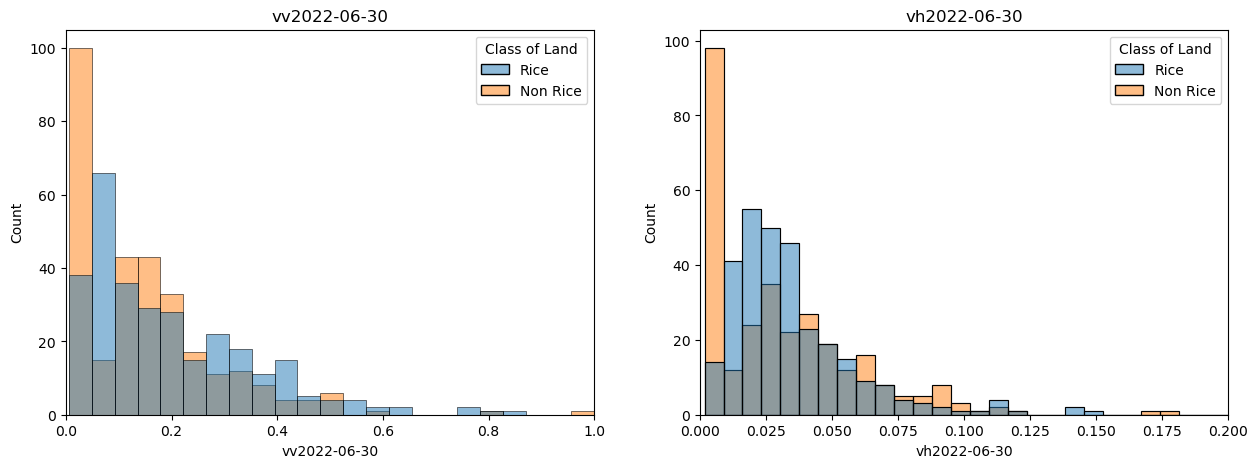

In [52]:
# In-season rice farming refers to regular rice cultivation during the rainy season. 
# It begins in May until October followed by a harvest period that ends in February
# VV and VH during June 2022 - cultivation period

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=data, x='vv2022-06-30',hue='Class of Land',ax=axes[0]).set(title='vv2022-06-30')
axes[0].set_xlim([0, 1])

sns.histplot(data=data, x='vh2022-06-30',hue='Class of Land',ax=axes[1]).set(title='vh2022-06-30')
axes[1].set_xlim([0, 0.2])

(0.0, 0.2)

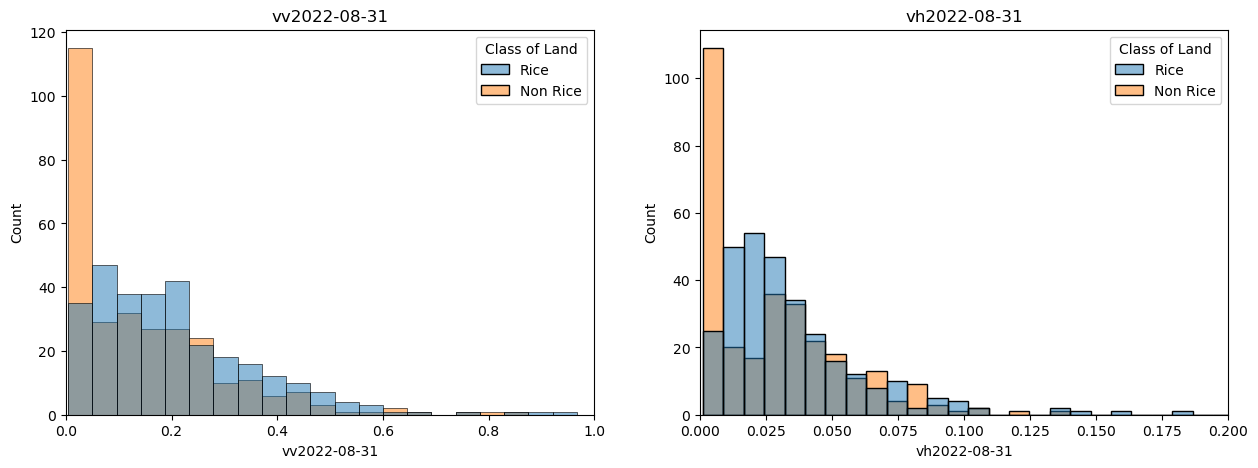

In [51]:
# In-season rice farming refers to regular rice cultivation during the rainy season. 
# It begins in May until October followed by a harvest period that ends in February
# VV and VH during Aug 2022 - cultivation period

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=data, x='vv2022-08-31',hue='Class of Land',ax=axes[0]).set(title='vv2022-08-31')
axes[0].set_xlim([0, 1])

sns.histplot(data=data, x='vh2022-08-31',hue='Class of Land',ax=axes[1]).set(title='vh2022-08-31')
axes[1].set_xlim([0, 0.2])

(0.0, 0.2)

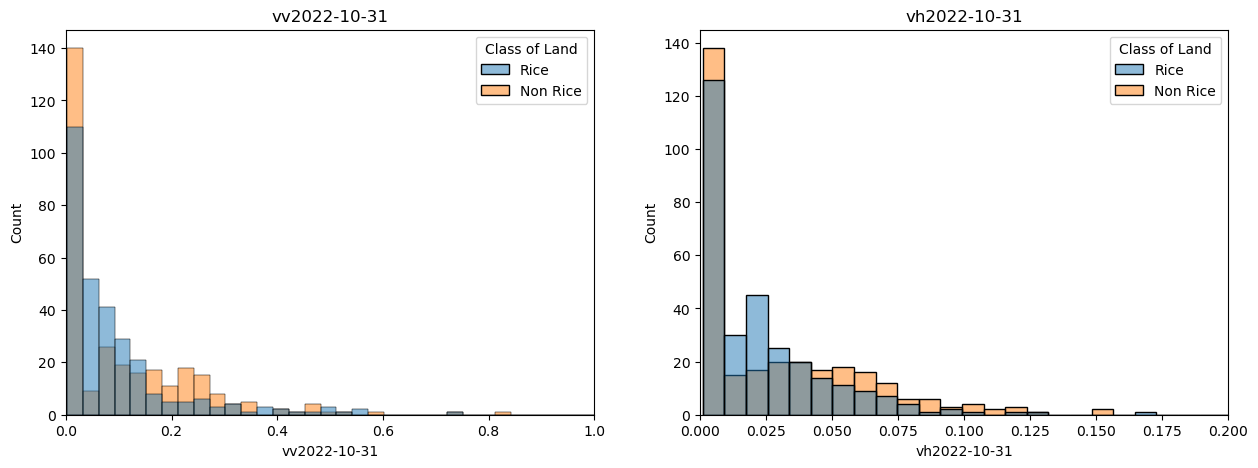

In [50]:
# In-season rice farming refers to regular rice cultivation during the rainy season. 
# It begins in May until October followed by a harvest period that ends in February
# VV and VH during Oct 2022 - cultivation period

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=data, x='vv2022-10-31',hue='Class of Land',ax=axes[0]).set(title='vv2022-10-31')
axes[0].set_xlim([0, 1])

sns.histplot(data=data, x='vh2022-10-31',hue='Class of Land',ax=axes[1]).set(title='vh2022-10-31')
axes[1].set_xlim([0, 0.2])

(0.0, 0.2)

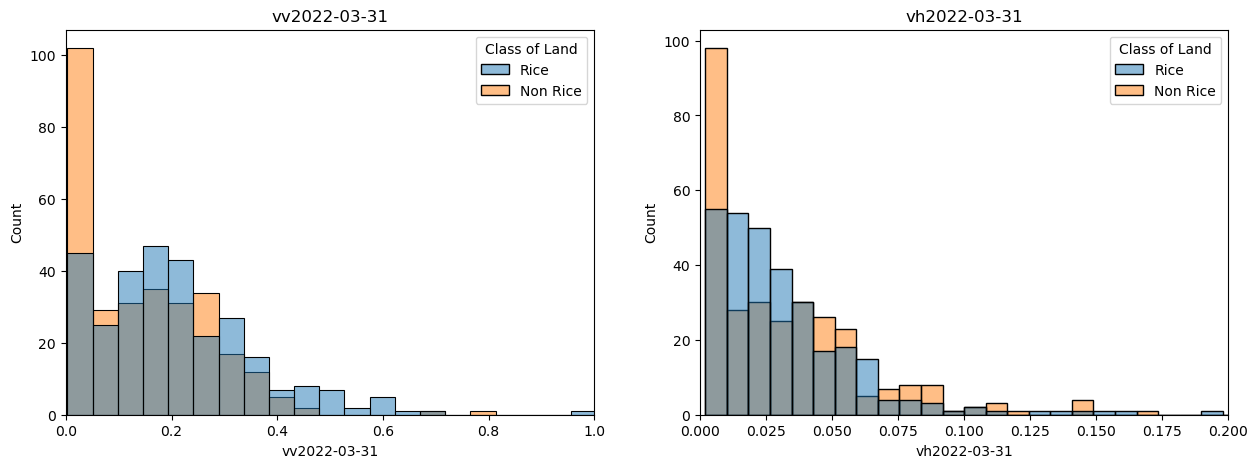

In [49]:
# In-season rice farming refers to regular rice cultivation during the rainy season. 
# It begins in May until October followed by a harvest period that ends in February
# VV and VH during Mar 2022 - harvesting period

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=data, x='vv2022-03-31',hue='Class of Land',ax=axes[0]).set(title='vv2022-03-31')
axes[0].set_xlim([0, 1])

sns.histplot(data=data, x='vh2022-03-31',hue='Class of Land',ax=axes[1]).set(title='vh2022-03-31')
axes[1].set_xlim([0, 0.2])

From above plots, we can see that majority of non-rice fields usually have low VV&VH values.

# Model development

In [22]:
df_data = pd.read_pickle('data.pkl')

In [23]:
df_submission = pd.read_pickle('submission_data.pkl')

## Experiment with pycaret

In [61]:
# !pip install --pre pycaret
from pycaret.classification import *

In [62]:
s = setup(df_data, target = 'Class of Land', profile=True)

,Description,Value
0,Session id,4579
1,Target,Class of Land
2,Target type,Binary
3,Target mapping,"Non Rice: 0, Rice: 1"
4,Original data shape,"(600, 26)"
5,Transformed data shape,"(600, 26)"
6,Transformed train set shape,"(420, 26)"
7,Transformed test set shape,"(180, 26)"
8,Numeric features,24
9,Categorical features,1


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [63]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8571,0.9177,0.8714,0.8489,0.8580,0.7143,0.7181,0.2280
et,Extra Trees Classifier,0.8476,0.9364,0.8571,0.8448,0.8492,0.6952,0.6980,0.3200
rf,Random Forest Classifier,0.8452,0.9224,0.8667,0.8316,0.8483,0.6905,0.6920,0.3860
lightgbm,Light Gradient Boosting Machine,0.8357,0.9229,0.8476,0.8291,0.8371,0.6714,0.6736,0.2100
knn,K Neighbors Classifier,0.8262,0.9031,0.8143,0.8358,0.8225,0.6524,0.6558,0.0810
ada,Ada Boost Classifier,0.8238,0.8912,0.8143,0.8308,0.8220,0.6476,0.6484,0.1780
dt,Decision Tree Classifier,0.7881,0.7881,0.7810,0.7922,0.7851,0.5762,0.5783,0.0790
lda,Linear Discriminant Analysis,0.7595,0.8023,0.7810,0.7499,0.7625,0.5190,0.5234,0.0740
ridge,Ridge Classifier,0.7333,0.0000,0.7095,0.7448,0.7248,0.4667,0.4693,0.0620
lr,Logistic Regression,0.7190,0.7880,0.7048,0.7278,0.7137,0.4381,0.4410,0.4550


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [64]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [65]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8934,0.8095,0.8095,0.8095,0.6190,0.6190
1,0.8333,0.9410,0.8571,0.8182,0.8372,0.6667,0.6674
2,0.8571,0.9263,0.9048,0.8261,0.8636,0.7143,0.7175
3,0.9048,0.9728,0.9048,0.9048,0.9048,0.8095,0.8095
4,0.7857,0.8594,0.7619,0.8000,0.7805,0.5714,0.5721
5,0.8571,0.9127,0.9048,0.8261,0.8636,0.7143,0.7175
6,0.8333,0.9172,0.8571,0.8182,0.8372,0.6667,0.6674
7,0.8571,0.9512,0.9048,0.8261,0.8636,0.7143,0.7175
8,0.8095,0.8707,0.8571,0.7826,0.8182,0.6190,0.6219


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8707,0.8571,0.7826,0.8182,0.6190,0.6219
1,0.8333,0.9252,0.8571,0.8182,0.8372,0.6667,0.6674
2,0.9048,0.9410,0.9524,0.8696,0.9091,0.8095,0.8132
3,0.9048,0.9615,0.9048,0.9048,0.9048,0.8095,0.8095
4,0.7857,0.8662,0.7619,0.8000,0.7805,0.5714,0.5721
5,0.8810,0.9365,0.9048,0.8636,0.8837,0.7619,0.7628
6,0.8333,0.9116,0.8571,0.8182,0.8372,0.6667,0.6674
7,0.8571,0.9524,0.9048,0.8261,0.8636,0.7143,0.7175
8,0.8095,0.8571,0.8571,0.7826,0.8182,0.6190,0.6219


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [67]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [68]:
predict_model(rf, df_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9517,0.9888,0,0,0,0.9033,0.9033


,Latitude and Longitude,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,vv2022-05-31,vh2022-06-30,...,vv2023-01-31,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31,Class of Land,prediction_label,prediction_score
0,"(10.323727047081501, 105.2516346045924)",0.025809,0.046758,0.040087,0.258022,0.011501,0.088195,0.041798,0.050357,0.020651,...,0.032296,0.024688,0.356259,0.018502,0.090875,0.035976,0.038166,Rice,Rice,0.94
1,"(10.322364360592521, 105.27843410554115)",0.028435,0.040619,0.005701,0.043889,0.036218,0.090976,0.009128,0.086131,0.026534,...,0.033698,0.034930,0.263210,0.014791,0.218032,0.018949,0.071743,Rice,Rice,0.97
2,"(10.321455902933202, 105.25254306225168)",0.042243,0.198050,0.065652,0.250058,0.024159,0.474126,0.046006,0.257310,0.036411,...,0.060927,0.024080,0.222509,0.027287,0.237095,0.031852,0.272413,Rice,Rice,0.70
3,"(10.324181275911162, 105.25118037576274)",0.032050,0.078635,0.031070,0.249539,0.007604,0.273698,0.044662,0.122891,0.030347,...,0.048524,0.059220,0.244447,0.079248,0.181485,0.055652,0.056386,Rice,Rice,0.90
4,"(10.324635504740822, 105.27389181724476)",0.013208,0.091704,0.004054,0.025380,0.024947,0.118164,0.019297,0.036611,0.062030,...,0.054595,0.018596,0.349119,0.027721,0.063309,0.092848,0.102218,Rice,Rice,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",0.027245,0.046894,0.013554,0.270339,0.004356,0.061393,0.022850,0.106196,0.016997,...,0.035077,0.003232,0.023702,0.003485,0.012488,0.002454,0.008812,Non Rice,Non Rice,0.50
596,"(10.01348875642372, 105.67361318732796)",0.022118,0.063891,0.017555,0.273152,0.003530,0.076637,0.008811,0.219475,0.018335,...,0.067073,0.003879,0.033681,0.003511,0.037849,0.009723,0.015819,Non Rice,Non Rice,0.86
597,"(10.013034527594062, 105.67361318732796)",0.035172,0.134629,0.022562,0.397861,0.015263,0.178932,0.019894,0.321736,0.056797,...,0.084863,0.021707,0.090829,0.012015,0.097578,0.036001,0.041303,Non Rice,Non Rice,0.55
598,"(10.012580298764401, 105.67361318732796)",0.010541,0.036208,0.012637,0.256354,0.004602,0.066129,0.032420,0.191806,0.029379,...,0.048333,0.002905,0.011732,0.003243,0.008442,0.003742,0.004128,Non Rice,Non Rice,0.62


In [70]:
save_model(rf, 'pycaret_rf')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     includ...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                      

In [71]:
save_model(best, 'pycaret_gbc')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     includ...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                    

In [72]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.9116,0.8095,0.8500,0.8293,0.6667,0.6674
1,0.8333,0.9229,0.8571,0.8182,0.8372,0.6667,0.6674
2,0.8810,0.9274,0.9048,0.8636,0.8837,0.7619,0.7628
3,0.8810,0.9388,0.8571,0.9000,0.8780,0.7619,0.7628
4,0.8095,0.8912,0.7619,0.8421,0.8000,0.6190,0.6219
5,0.8333,0.9501,0.9048,0.7917,0.8444,0.6667,0.6736
6,0.7857,0.8798,0.8095,0.7727,0.7907,0.5714,0.5721
7,0.8810,0.9683,0.9524,0.8333,0.8889,0.7619,0.7698
8,0.8095,0.8821,0.8095,0.8095,0.8095,0.6190,0.6190


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
submission_rf = predict_model(rf, df_submission)
submission_rf = submission_rf[['Latitude and Longitude','prediction_label']]
submission_rf.columns=['Latitude and Longitude','Class of Land']
submission_rf

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [28]:
submission_rf

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [34]:
submission_rf.to_csv("challenge_1_submission_rice_crop_prediction_rf.csv",index = False)

## Experiment with Sklearn RandomForestClassifier

In [59]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report

import pickle

In [54]:
df = data.copy()

In [55]:
X = df.drop(columns=['Class of Land','Latitude and Longitude'])
y = df['Class of Land']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=777)

In [56]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
model = RandomForestClassifier()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(y_pred,y_test)))

Accuracy 83.89%


,Latitude and Longitude,vh2021-12-31,vv2021-12-31,vh2022-01-31,vv2022-01-31,vh2022-03-31,vv2022-03-31,vh2022-04-30,vv2022-04-30,vh2022-05-31,...,vh2022-08-31,vv2022-08-31,vh2022-09-30,vv2022-09-30,vh2022-10-31,vv2022-10-31,vh2022-11-30,vv2022-11-30,vh2023-01-31,vv2023-01-31
0,"(10.18019073690894, 105.32022315786804)",0.024887,0.420412,0.032572,0.026235,0.074218,0.326084,0.019006,0.194885,0.024442,...,0.017848,0.258637,0.032971,0.059533,0.029771,0.067935,0.042868,0.210826,0.021734,0.036966
1,"(10.561107033461816, 105.12772097986661)",0.029834,0.102679,0.043230,0.083787,0.013753,0.054234,0.033759,0.110243,0.023815,...,0.028224,0.140003,0.031743,0.142211,0.019296,0.140753,0.023259,0.160994,0.017828,0.051285
2,"(10.623790611954897, 105.13771401411867)",0.043791,0.063958,0.024425,0.067639,0.007534,0.042714,0.015497,0.032946,0.046273,...,0.020280,0.158912,0.007301,0.367683,0.022714,0.130159,0.034239,0.052218,0.076482,0.106362
3,"(10.583364246115156, 105.23946127195805)",0.027628,0.068491,0.034561,0.092048,0.028700,0.021269,0.040093,0.228477,0.021459,...,0.030894,0.151874,0.022912,0.162411,0.037030,0.066545,0.046395,0.360840,0.030656,0.067947
4,"(10.20744446668854, 105.26844107128906)",0.031317,0.405673,0.028063,0.031049,0.060399,0.265872,0.060655,0.150903,0.030741,...,0.010483,0.649276,0.023612,0.054151,0.031875,0.049799,0.003434,0.022248,0.037201,0.031332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,"(10.308283266873062, 105.50872812216863)",0.023306,1.279871,0.042283,1.552791,0.039890,1.037688,0.035218,0.894476,0.032241,...,0.018037,0.865080,0.009503,0.789477,0.021589,0.326405,0.020802,0.636473,0.024804,1.191021
246,"(10.582910017285496, 105.23991550078767)",0.017510,0.040552,0.041834,0.063640,0.008622,0.077661,0.019350,0.427270,0.023298,...,0.012358,0.216565,0.021334,0.112711,0.027071,0.097601,0.023541,0.155663,0.031585,0.052805
247,"(10.581547330796518, 105.23991550078767)",0.015218,0.034978,0.039442,0.057817,0.010188,0.017719,0.012933,0.575292,0.015842,...,0.010555,0.091680,0.032574,0.133027,0.048473,0.071016,0.045243,0.080795,0.062070,0.072308
248,"(10.629241357910818, 105.15315779432643)",0.008690,0.017403,0.030527,0.209669,0.054499,0.115431,0.008939,0.409741,0.073876,...,0.008816,0.016422,0.004519,0.017020,0.003895,0.005679,0.005485,0.009926,0.029364,0.199689


In [75]:
y_sub = model.predict(df_submission.drop(columns=['Latitude and Longitude']))

In [81]:
submission_sklrfc = df_submission[['Latitude and Longitude']]
submission_sklrfc.columns=['id']
submission_sklrfc['target'] = y_sub
submission_sklrfc

,id,target
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [82]:
submission_sklrfc.to_csv("challenge_1_submission_rice_crop_prediction_sklrfc.csv",index = False)

In [60]:
pickle.dump(model, open('sklearn_RandomForestClassifier.pkl', 'wb'))